In [1]:
import numpy as np
import math
import pandas as pd
import pythran
import matplotlib.pyplot as plt

In [2]:
%%writefile .pythranrc
[compiler]
include_dirs=/usr/include/openblas

Overwriting .pythranrc


In [3]:
%load_ext pythran.magic

In [16]:
np.random.seed(123)

In [33]:
def sir(u,parms,t):
    bet,gamm,iota,N,dt=parms
    S,I,R,Y=u
    lambd = bet*(I+iota)/N
    ifrac = 1.0 - math.exp(-lambd*dt)
    rfrac = 1.0 - math.exp(-gamm*dt)
    infection = np.random.binomial(S,ifrac)
    recovery = np.random.binomial(I,rfrac)
    return [S-infection,I+infection-recovery,R+recovery,Y+infection]

def simulate():
    parms = [4, 2.7, 0.01, 1000.0, 0.1]
    tf = 200
    tl = 2001
    t = np.linspace(0,tf,tl)
    S = np.zeros(tl)
    I = np.zeros(tl)
    R = np.zeros(tl)
    Y = np.zeros(tl)
    u = [999,1,0,0]
    S[0],I[0],R[0],Y[0] = u
    for j in range(1,tl):
        u = sir(u,parms,t[j])
        S[j],I[j],R[j],Y[j] = u
    return {'t':t,'S':S,'I':I,'R':R,'Y':Y}

In [34]:
%timeit simulate()

14.4 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
sir_out = pd.DataFrame(simulate())

In [36]:
sir_out

,t,S,I,R,Y
0,0.0,999.0,1.0,0.0,0.0
1,0.1,999.0,1.0,0.0,0.0
2,0.2,997.0,3.0,0.0,2.0
3,0.3,994.0,6.0,0.0,5.0
4,0.4,988.0,12.0,0.0,11.0
5,0.5,985.0,12.0,3.0,14.0
6,0.6,978.0,15.0,7.0,21.0
7,0.7,972.0,19.0,9.0,27.0
8,0.8,966.0,19.0,15.0,33.0
9,0.9,960.0,24.0,16.0,39.0


In [37]:
#Como el código anterior sólo utiliza tiempos simples de Python y Numpy, 
#es sencillo obtener versiones compiladas del código utilizando Pythran.

#pythran export sirp(float64 list, float64 list, float64)
def sirp(u,parms,t):
    bet,gamm,iota,N,dt=parms
    S,I,R,Y=u
    lambd = bet*(I+iota)/N
    ifrac = 1.0 - math.exp(-lambd*dt)
    rfrac = 1.0 - math.exp(-gamm*dt)
    infection = np.random.binomial(S,ifrac)
    recovery = np.random.binomial(I,rfrac)
    return [S-infection,I+infection-recovery,R+recovery,Y+infection]

#pythran export simulatep()
def simulatep():
    parms = [4, 2.7, 0.01, 1000.0, 0.1]
    tf = 200
    tl = 5000
    t = np.linspace(0,tf,tl)
    S = np.zeros(tl)
    I = np.zeros(tl)
    R = np.zeros(tl)
    Y = np.zeros(tl)
    u = [999,1,0,0]
    S[0],I[0],R[0],Y[0] = u
    for j in range(1,tl):
        u = sirp(u,parms,t[j])
        S[j],I[j],R[j],Y[j] = u
    return {'t':t,'S':S,'I':I,'R':R,'Y':Y}

In [38]:
%timeit simulatep()

37.7 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
sir_outp = pd.DataFrame(simulatep())

In [40]:
sir_outp

,t,S,I,R,Y
0,0.000000,999.0,1.0,0.0,0.0
1,0.040008,998.0,2.0,0.0,1.0
2,0.080016,996.0,4.0,0.0,3.0
3,0.120024,994.0,5.0,1.0,5.0
4,0.160032,992.0,6.0,2.0,7.0
5,0.200040,989.0,7.0,4.0,10.0
6,0.240048,984.0,10.0,6.0,15.0
7,0.280056,979.0,14.0,7.0,20.0
8,0.320064,974.0,16.0,10.0,25.0
9,0.360072,966.0,21.0,13.0,33.0


In [41]:
plt.style.use("seaborn-whitegrid")

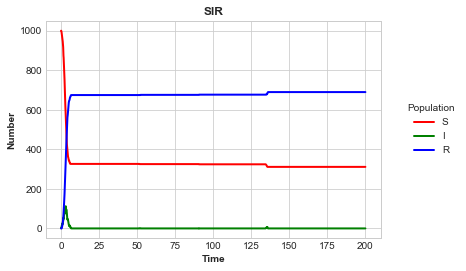

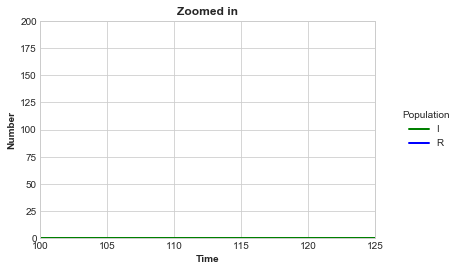

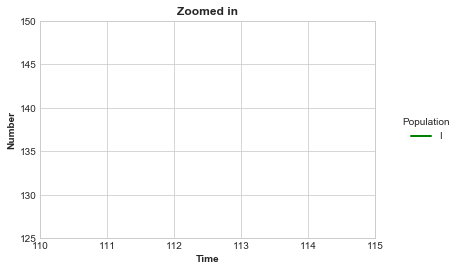

In [42]:
#Visualización

sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","R","",data=sir_out,color="blue",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)
plt.title("SIR",fontweight="bold")
plt.show()

#Zoom in
ax2 = plt.subplot()
plt.axis(xmin=100,xmax=125,yminn=50,ymax=200)  
iline = ax2.plot("t","I","",data=sir_out,color="green",linewidth=2)
rline = ax2.plot("t","R","",data=sir_out,color="blue",linewidth=2)

plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

ax2.set_title('Zoomed in',fontweight="bold")
plt.show()

#Zoom in 2
ax3 = plt.subplot()
plt.axis(xmin=110,xmax=115,ymin=125,ymax=150)
iline = ax3.plot("t","I","",data=sir_out,color="green",linewidth=2)

plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

ax3.set_title('Zoomed in',fontweight="bold")
plt.show()